In [1]:
from pathlib import Path

from skimage.color import label2rgb
from skimage.io import imread, imsave
from skimage.measure import label
from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (10, 10)

In [31]:
data_dir = Path("/g/kreshuk/data/from_edoardo/cryoSEM/for_alyona/data")
segmentation_files = sorted(list((Path("/g/kreshuk/buglakova/data") / "cells_corrected").glob("*")))
image_files = sorted(list((data_dir / "F107_bin2_619-639_frames").glob("*")))

segmentations = [imread(fname) for fname in segmentation_files]
images = [imread(fname) for fname in image_files]


output_dir = Path("/g/kreshuk/buglakova/data") / "multiclass_delete_borders"
output_dir.mkdir(exist_ok=True)

In [32]:
def get_background_mask(segm, img):
    # Find out of sample part
    bg = label(img == 0)
    component_sizes = [np.count_nonzero(bg == i) for i in np.unique(bg)[1:]]
    bg_ind = np.argmax(component_sizes) + 1
    bg = (bg == bg_ind)
    return bg


def convert_segmentation(segm, img):
    # Find out of sample part
    bg = label(img == 0)
    component_sizes = [np.count_nonzero(bg == i) for i in np.unique(bg)[1:]]
    bg_ind = np.argmax(component_sizes) + 1
    bg = (bg == bg_ind)
    fg = (bg != bg_ind)

    # Get only boundary
    multiclass_label = label(segm, background=-1)
    component_sizes = [np.count_nonzero(multiclass_label == i) for i in np.unique(multiclass_label)]
    boundary_ind = np.argmax(component_sizes) + 1
    boundary = (multiclass_label == boundary_ind) * fg

    # Set extracellular part to 0
    multiclass_label = multiclass_label * segm

    # Create final segmentation
    multiclass_label = multiclass_label + 2
    multiclass_label[boundary] = 1
    multiclass_label[bg] = 0

    return multiclass_label


def delete_border(segm, img):
    bg = get_background_mask(segm, img)
    instance_segm = convert_segmentation(segm, img)

    dilated = bg
    for _ in range(8):
        dilated = binary_dilation(dilated)

    dilated = 1 - dilated

    instance_segm = instance_segm * dilated

    # Delete small errors of automatic segmentation
    n = 200
    for i in np.unique(instance_segm):
        if len(instance_segm[instance_segm == i]) < n:
            instance_segm[instance_segm == i] = 0

    mask = bg
    for _ in range(3):
        mask = binary_dilation(mask)
    mask = 1 - mask

    watershed_segm = watershed(image=img, markers=instance_segm, mask=mask)

    return watershed_segm


In [27]:
i = 7
watershed_segm = delete_border(segmentations[i], images[i])

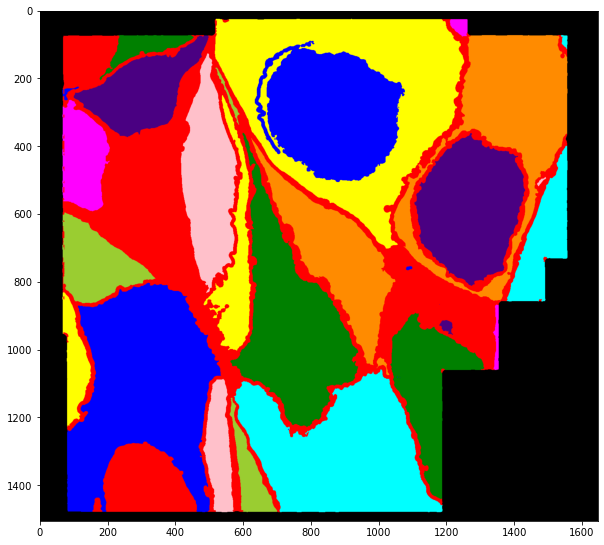

In [28]:
plt.imshow(label2rgb(watershed_segm))

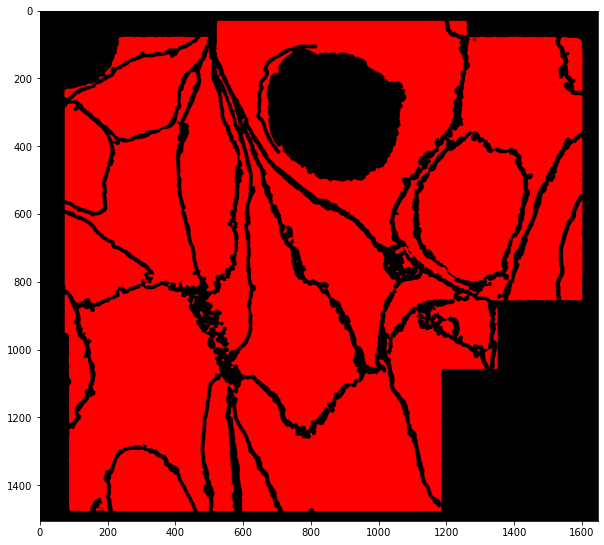

In [16]:
plt.imshow(label2rgb(segmentations[i]))

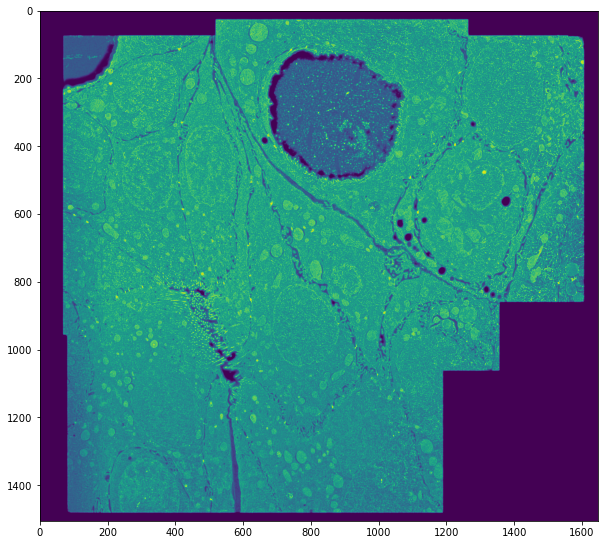

In [17]:
plt.imshow(images[i])

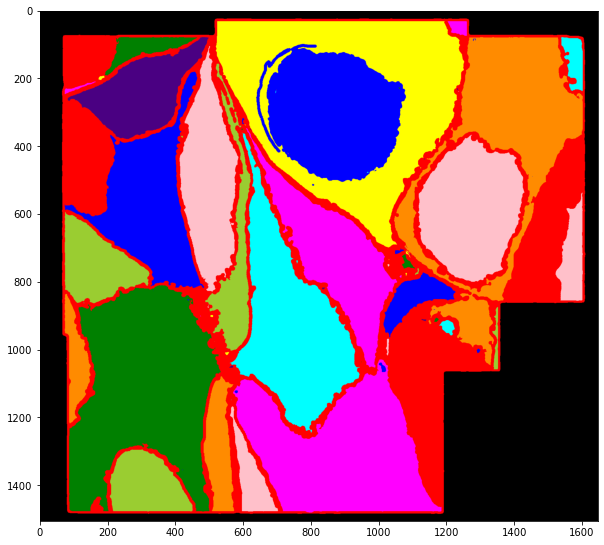

In [18]:
i = 1
multiclass_label = convert_segmentation(segmentations[i], images[i])
plt.imshow(label2rgb(multiclass_label))

In [33]:
multiclass_labels = [delete_border(segm, img) for segm, img in zip(segmentations, images)]
for fname, segm in zip(segmentation_files, multiclass_labels):
    print(output_dir / fname.name)
    imsave(output_dir / fname.name, segm)

/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_01.tiff
/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_02.tiff
/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_03.tiff
/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_04.tiff
/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_05.tiff
/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_06.tiff


/tmp/ipykernel_166817/24781924.py:4: UserWarning: /g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_01.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/24781924.py:4: UserWarning: /g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_02.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/24781924.py:4: UserWarning: /g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_03.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/24781924.py:4: UserWarning: /g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_04.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/24781924.py:4: UserWarning: /g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_05.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipyke

/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_07.tiff
/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_08.tiff
/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_09.tiff
/g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_10.tiff


/tmp/ipykernel_166817/24781924.py:4: UserWarning: /g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_07.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/24781924.py:4: UserWarning: /g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_08.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/24781924.py:4: UserWarning: /g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_09.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/24781924.py:4: UserWarning: /g/kreshuk/buglakova/data/multiclass_delete_borders/F107_bin2_619-639_cells_10.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)


In [20]:
output_dir = Path("/g/kreshuk/buglakova/data") / "multiclass"
multiclass_labels = [convert_segmentation(segm, img) for segm, img in zip(segmentations, images)]
for fname, segm in zip(segmentation_files, multiclass_labels):
    print(output_dir / fname.name)
    imsave(output_dir / fname.name, segm)

/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_01.tiff
/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_02.tiff
/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_03.tiff


/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_01.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_02.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_03.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)


/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_04.tiff
/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_05.tiff
/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_06.tiff
/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_07.tiff


/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_04.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_05.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_06.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_07.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)


/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_08.tiff
/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_09.tiff
/g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_10.tiff


/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_08.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_09.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)
/tmp/ipykernel_166817/2408531567.py:5: UserWarning: /g/kreshuk/buglakova/data/multiclass/F107_bin2_619-639_cells_10.tiff is a low contrast image
  imsave(output_dir / fname.name, segm)


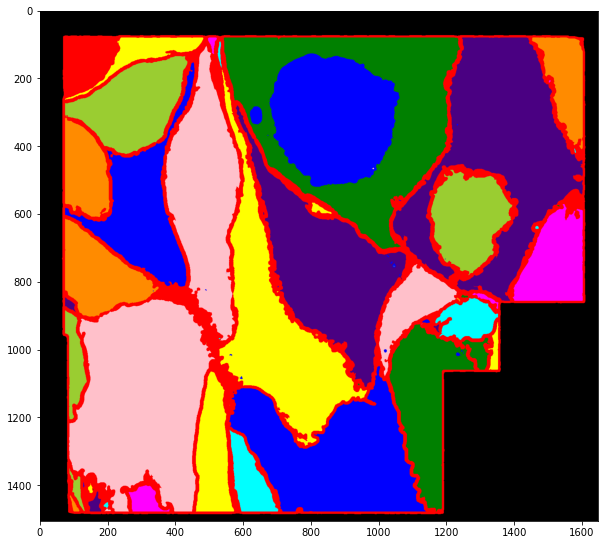

In [113]:

plt.imshow(label2rgb(multiclass_labels[0]))